## Import Library

In [ ]:
# install library
!pip install -q Sastrawi
!pip install -q emoji
!pip install -q scikit-optimize

In [ ]:
# load necessary library
import string
from collections import Counter
import re
from wordcloud import WordCloud
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import emoji
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
sns.set(
    style='darkgrid',
    rc={
        'figure.figsize': (12, 8),
    }
)

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

from umap import UMAP
import plotly.express as px

from scipy.sparse import hstack
from scipy.sparse import csr_matrix
import pickle

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## Load Dataset

In [ ]:
# path dataset
path = '/content/ulasan_tokopedia.csv'
# path2 = '/content/ulasan_tokopedia2.csv'

# read dataset
df = pd.read_csv(path, sep=',', encoding='latin-1')

In [ ]:
df.head()

,Waktu,Username,Ulasan
0,Hari ini,F***i,kualitas barang original dan top \n\npenjualny...
1,Hari ini,A***s,mksh tko yg amanah
2,1 hari lalu,Jelita,Alhamdulillah barang nya sudah sampai di rumah...
3,1 hari lalu,Mohamad,"barang sudh smpai, pengiriman cepat, wrna sesu..."
4,1 hari lalu,Sea,like luar biasaaaaa


## Data Understanding

In [ ]:
# check shape data
df.shape

(956, 3)

In [ ]:
# check info data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 956 entries, 0 to 955
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Waktu     956 non-null    object
 1   Username  956 non-null    object
 2   Ulasan    956 non-null    object
dtypes: object(3)
memory usage: 22.5+ KB


In [ ]:
# descriptive statistics
df.describe(include='all').T

,count,unique,top,freq
Waktu,956,21,11 bulan lalu,210
Username,956,365,a***a,24
Ulasan,956,491,"mantab, sesuai pesanan, packing juga tebel jad...",18


## Data Preprocessing

In [ ]:
# define rules for labeling
def is_only_emoticon(text):
    return all(not c.isalnum() for c in text.strip()) and bool(re.search(r'[^\w\s]', text))

def label_reviews(reviews):
    labels = []
    review_counter = Counter(reviews)

    for review in reviews:
        if is_only_emoticon(review) or review_counter[review] > 1:
            labels.append('Fake')
        else:
            labels.append('Real')

    return labels

# apply function
df['Label'] = label_reviews(df['Ulasan'].tolist())
df.head()

,Waktu,Username,Ulasan,Label
0,Hari ini,F***i,kualitas barang original dan top \n\npenjualny...,Real
1,Hari ini,A***s,mksh tko yg amanah,Fake
2,1 hari lalu,Jelita,Alhamdulillah barang nya sudah sampai di rumah...,Real
3,1 hari lalu,Mohamad,"barang sudh smpai, pengiriman cepat, wrna sesu...",Real
4,1 hari lalu,Sea,like luar biasaaaaa,Real


In [ ]:
# check label distribution
df['Label'].value_counts()

,count
Label,
Fake,562
Real,394


In [ ]:
# function for cleaning
def clean_text(text):
    if not isinstance(text, str):
        text = str(text)
    text = text.lower() # casefolding
    text = text.strip(' ') # menghapus spasi di awal dan di akhir
    text = re.sub(r'\d+', '', text) # menghapus angka
    text = text.translate(str.maketrans('','', string.punctuation)) # menghapus punctuation
    text = re.sub(r'\b[a-zA-Z]\b', '', text) # menghapus kata yang hanya terdiri dari satu huruf
    text = re.sub(r'\s+', ' ', text) # menghapus spasi berlebih
    text = emoji.replace_emoji(text, replace='') # menghapus emoji
    emoticon_pattern = re.compile(r"""
        (?::|;|=) # Kolom, titik koma, atau tanda sama dengan untuk wajah
        (?:-)? # Tanda minus opsional
        (?:\)|\(|D|P|O|/|\|S) # char yang menunjukkan ekspresi
        """, re.VERBOSE)
    text = emoticon_pattern.sub(r'', text) # menghapus emoticon
    tokens = word_tokenize(text) # tokenisasi
    stop_words = set(stopwords.words('indonesian')) # menghapus stopwords
    tokens = [word for word in tokens if word not in stop_words] # menghapus stopwords
    factory = StemmerFactory() # stemming
    stemmer = factory.create_stemmer()
    tokens = [stemmer.stem(word) for word in tokens]
    text = ' '.join(tokens)
    return text

In [ ]:
# apply function to Ulasan feature
df['Ulasan_Clean'] = df['Ulasan'].apply(clean_text)
df.head()

,Waktu,Username,Ulasan,Label,Ulasan_Clean
0,Hari ini,F***i,kualitas barang original dan top \n\npenjualny...,Real,kualitas barang original top jual top responsif
1,Hari ini,A***s,mksh tko yg amanah,Fake,mksh tko yg amanah
2,1 hari lalu,Jelita,Alhamdulillah barang nya sudah sampai di rumah...,Real,alhamdulillah barang nya rumah sesuai pesan ma...
3,1 hari lalu,Mohamad,"barang sudh smpai, pengiriman cepat, wrna sesu...",Real,barang sudh smpai kirim cepat wrna sesuai pesan
4,1 hari lalu,Sea,like luar biasaaaaa,Real,like biasaaaaa


In [ ]:
# # save result after cleaning
# df.to_csv('dataset_tokoped3_clean.csv', index=False)

# read dataset after preprocessing
# df = pd.read_csv('dataset_tokoped3_clean.csv')

In [ ]:
# top 5 data with real label
df_real = df[df['Label'] == 'Real']
df_real.sample(5, random_state=1)

,Waktu,Username,Ulasan,Label,Ulasan_Clean
107,1 bulan lalu,dwi,â­â­â­â­â­ terima kasih bonusnya ðð,Real,terima kasih bonus
271,3 bulan lalu,M***i,Alhamdulillah pesanan sampai dengan aman tidak...,Real,alhamdulillah pesan aman lecet apa barang orig...
421,6 bulan lalu,e***n,seller responsif dan barang sesuai deskripsi.,Real,seller responsif barang sesuai deskripsi
152,2 bulan lalu,sutaryo,warna sesuai\npelayanan mantaappppp,Real,warna sesuai layan mantaappppp
253,3 bulan lalu,h***i,produk sesuai pesanan terimakasih seller langg...,Real,produk sesuai pesan terimakasih seller langgan


In [ ]:
# top 5 data with fake label
df_fake = df[df['Label'] == 'Fake']
df_fake.sample(5, random_state=1)

,Waktu,Username,Ulasan,Label,Ulasan_Clean
301,3 bulan lalu,A***s,mksh tko yg amanah,Fake,mksh tko yg amanah
867,11 bulan lalu,sopian,Ada garansi resmi Spesifikasi sesuai Barangnya...,Fake,garansi resmi spesifikasi sesuai barang origin...
764,11 bulan lalu,Dylan,MANTAPPPP pengiriman cepat barang original mas...,Fake,mantapppp kirim cepat barang original segel ju...
910,Lebih dari 1 tahun lalu,B***g,ok mantap,Fake,ok mantap
749,11 bulan lalu,Ardiyan,"mantap, harga murah, segel , ori, utuh, packin...",Fake,mantap harga murah segel ori utuh packing aman


In [ ]:
# check review duplicate
df.duplicated().sum()

np.int64(434)

## Eksploratory Data Analysis (EDA)

In [ ]:
# check for username + review combinations that appear more than 1 time
dup_user_review = df.groupby(['Username', 'Ulasan']).size().reset_index(name='Jumlah')
dup_user_review = dup_user_review[dup_user_review['Jumlah'] > 1]

print('Username dengan isi review yang diulang:')
print(dup_user_review.sort_values(by='Jumlah', ascending=False))

Username dengan isi review yang diulang:
       Username                                             Ulasan  Jumlah
15        A***r  barang masih di segel waktu sampai di lokasi. ...      18
50   Andriansah    segel dan berfungsi dengan Baik.. Tq u ðð½      18
56      Ardiyan  mantap, harga murah, segel , ori, utuh, packin...      18
138       F***a  mantab, sesuai pesanan, packing juga tebel jad...      18
117       Dylan  MANTAPPPP pengiriman cepat barang original mas...      18
..          ...                                                ...     ...
420      albert  barangnay oke, mulus, pengiriman cepet, kveral...       2
475       rizki           teimakasih pesanan sampai dengan selamat       2
431       c***a                  barang sudah diterima dengan baik       2
487  syukurilah  kurir rekomendasi yang tidak recomended 24 jam...       2
488       t***y  barang sesuai pesanan oke bangat sellernya man...       2

[94 rows x 3 columns]


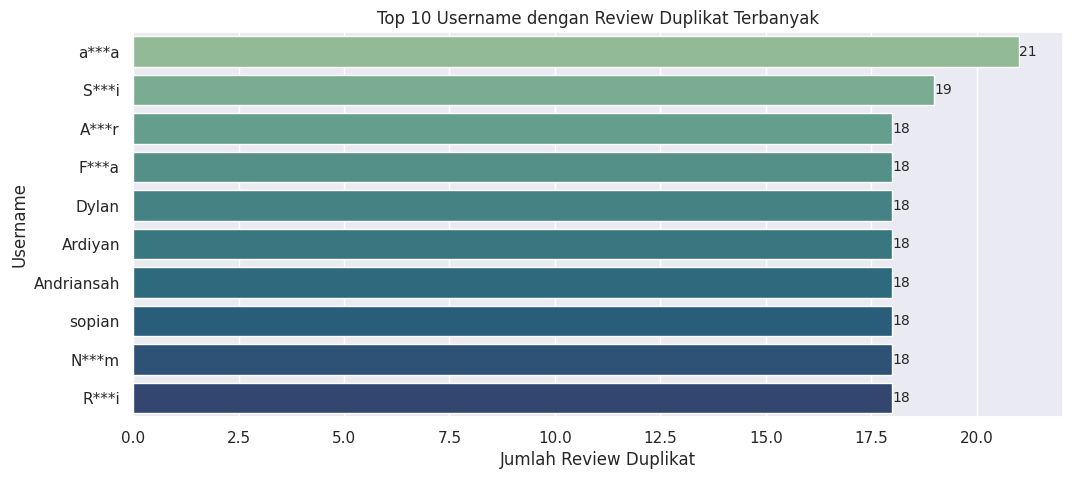

In [ ]:
# most Reviews per user visualization (potential spammers)
top_dup_users = dup_user_review.groupby('Username')['Jumlah'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 5))
ax = sns.barplot(x=top_dup_users.values, y=top_dup_users.index, palette='crest')
for container in ax.containers:
    ax.bar_label(container, size=10, label_type='edge')
plt.title('Top 10 Username dengan Review Duplikat Terbanyak')
plt.xlabel('Jumlah Review Duplikat')
plt.ylabel('Username')
plt.show()

In [ ]:
# drop duplicated
df.drop_duplicates(inplace=True)

In [ ]:
# shape dataset after drop duplicated
df.shape

(522, 5)

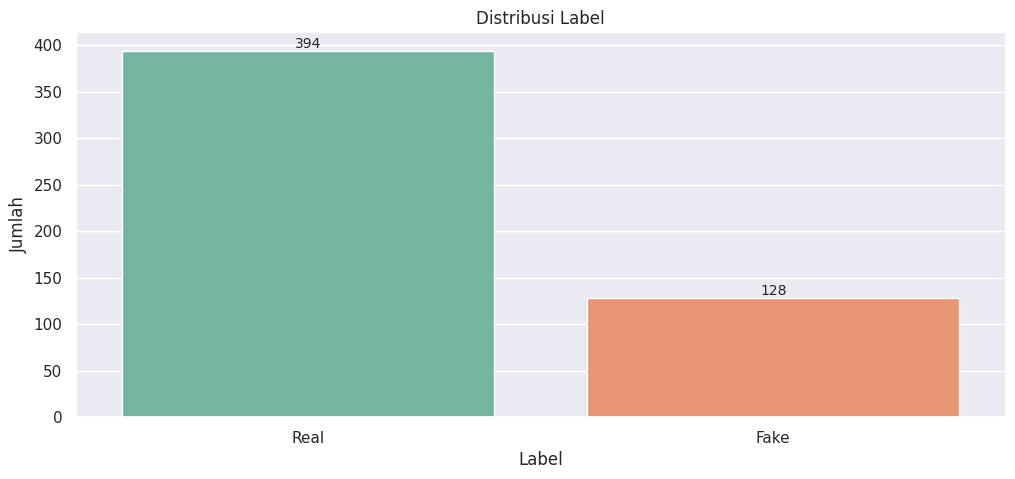

In [ ]:
# visualize label distribution
plt.figure(figsize=(12, 5))
ax = sns.countplot(data=df, x='Label', palette='Set2')
for container in ax.containers:
    ax.bar_label(container, size=10, label_type='edge')
plt.title('Distribusi Label')
plt.xlabel('Label')
plt.ylabel('Jumlah')
plt.show()

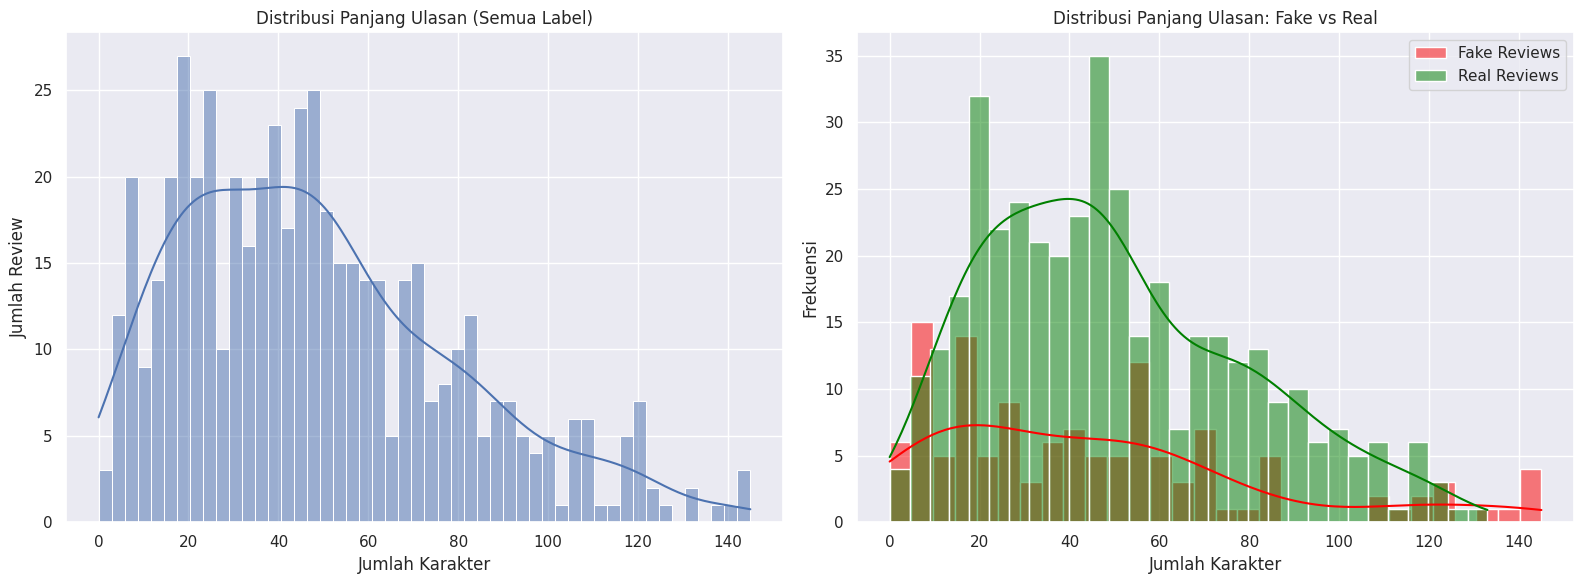

In [ ]:
# visualization review length review
df['Ulasan_Length'] = df['Ulasan_Clean'].astype(str).apply(len)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# overall review length distribution
sns.histplot(data=df, x='Ulasan_Length', bins=50, kde=True, ax=axes[0])
axes[0].set_title('Distribusi Panjang Ulasan (Semua Label)')
axes[0].set_xlabel('Jumlah Karakter')
axes[0].set_ylabel('Jumlah Review')

# Fake vs Real review length distribution
sns.histplot(df[df['Label'] == 'Fake']['Ulasan_Length'], color='red', kde=True, label='Fake Reviews', bins=30, ax=axes[1])
sns.histplot(df[df['Label'] == 'Real']['Ulasan_Length'], color='green', kde=True, label='Real Reviews', bins=30, ax=axes[1])
axes[1].set_title('Distribusi Panjang Ulasan: Fake vs Real')
axes[1].set_xlabel('Jumlah Karakter')
axes[1].set_ylabel('Frekuensi')
axes[1].legend()

plt.tight_layout()
plt.show()

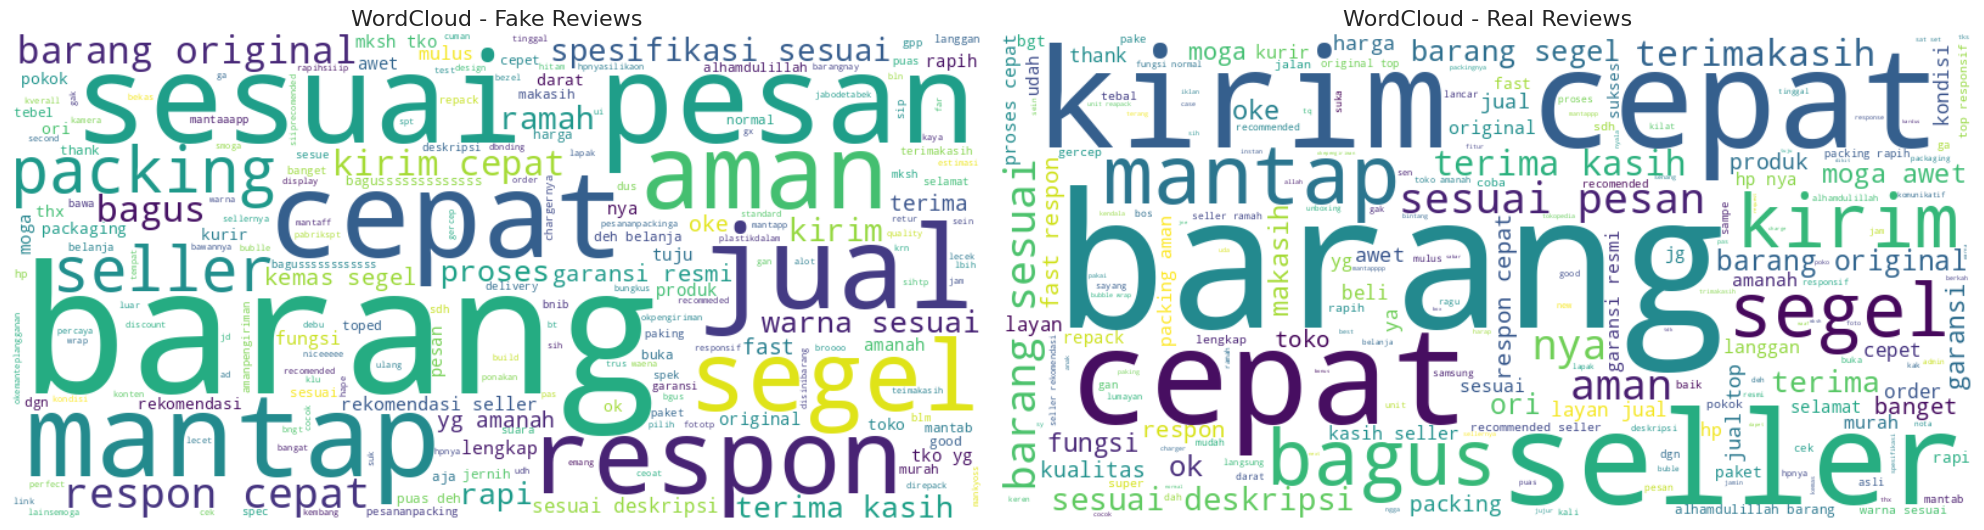

In [ ]:
# sanity check fake vs real
fake_text = " ".join(df[df['Label'] == 'Fake']['Ulasan_Clean'].dropna())
real_text = " ".join(df[df['Label'] == 'Real']['Ulasan_Clean'].dropna())

# function for wordcloud
def generate_wordcloud(text, title, position):
    plt.subplot(1, 2, position)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)

plt.figure(figsize=(20, 8))
generate_wordcloud(fake_text, 'WordCloud - Fake Reviews', 1)
generate_wordcloud(real_text, 'WordCloud - Real Reviews', 2)
plt.tight_layout()
plt.show()

In [ ]:
# function for tokenize
def tokenize_text(text):
    return nltk.word_tokenize(text.lower())

# filter review based Label (Fake vs Real)
word_frequency_fake = df[df['Label'] == 'Fake']['Ulasan_Clean']
word_frequency_real = df[df['Label'] == 'Real']['Ulasan_Clean']

# tokenize
fake_words = [word for review in word_frequency_fake for word in tokenize_text(review)]
real_words = [word for review in word_frequency_real for word in tokenize_text(review)]

fake_freq_dic = FreqDist(fake_words)
real_freq_dic = FreqDist(real_words)

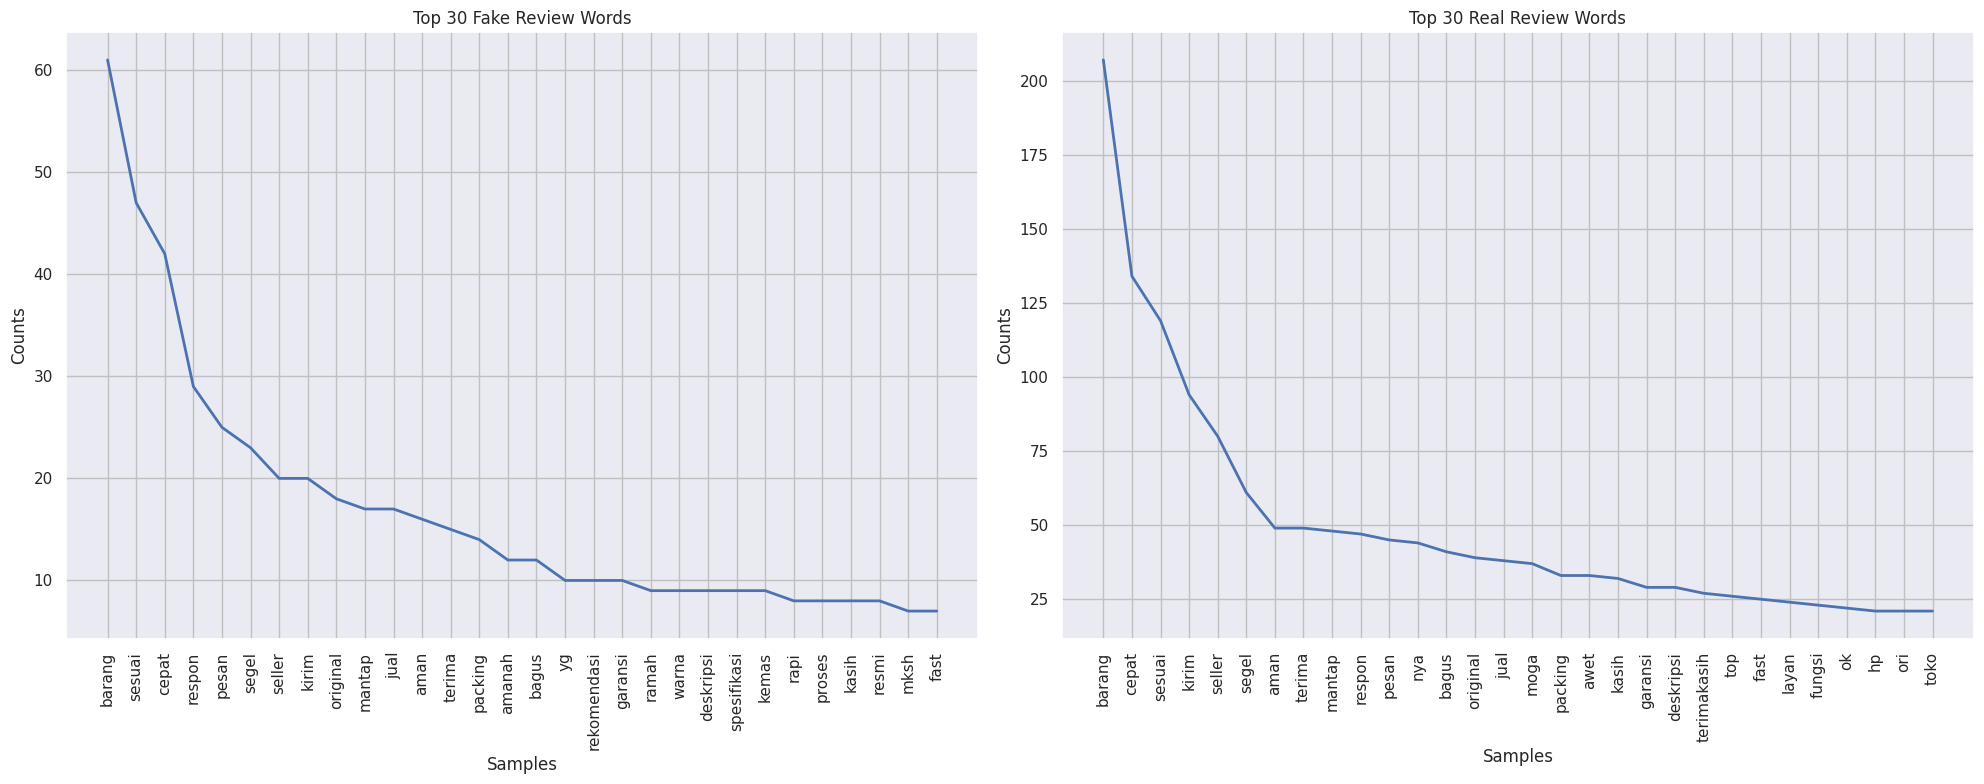

In [ ]:
# visualize top 30
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
fake_freq_dic.plot(30, title='Top 30 Fake Review Words')

plt.subplot(1, 2, 2)
real_freq_dic.plot(30, title='Top 30 Real Review Words')

plt.tight_layout()
plt.show()

In [ ]:
# sanity check with UMAP
reducer = UMAP(random_state=42)

# define tfidf
tfidf = TfidfVectorizer()
response = tfidf.fit_transform(df['Ulasan_Clean'])

X_umap = reducer.fit_transform(response.toarray())

df['umap_1'] = X_umap[:, 0]
df['umap_2'] = X_umap[:, 1]

fig = px.scatter(
    df, x='umap_1', y='umap_2', color='Label',
    title='UMAP Visualization of Reviews (Fake vs Real)', text='Ulasan_Clean'
)
fig.update_traces(marker=dict(size=5, opacity=0.7))
fig.update_layout(height=650)
fig.show()

## Data Modelling

In [ ]:
# encode label
def encode_label(label):
  label = {
      'Real': 0,
      'Fake': 1
  }

  df['Target'] = df['Label'].map(label)

  return df

df = encode_label(df)
df.head()

,Waktu,Username,Ulasan,Label,Ulasan_Clean,Ulasan_Length,umap_1,umap_2,Target
0,Hari ini,F***i,kualitas barang original dan top \n\npenjualny...,Real,kualitas barang original top jual top responsif,48,2.858544,4.328305,0
1,Hari ini,A***s,mksh tko yg amanah,Fake,mksh tko yg amanah,18,0.965499,4.729696,1
2,1 hari lalu,Jelita,Alhamdulillah barang nya sudah sampai di rumah...,Real,alhamdulillah barang nya rumah sesuai pesan ma...,51,0.364408,0.988967,0
3,1 hari lalu,Mohamad,"barang sudh smpai, pengiriman cepat, wrna sesu...",Real,barang sudh smpai kirim cepat wrna sesuai pesan,47,-1.366911,-0.477344,0
4,1 hari lalu,Sea,like luar biasaaaaa,Real,like biasaaaaa,14,-0.233600,1.904239,0


In [ ]:
# encode Username feature
username_encoder = LabelEncoder()
df['Username_encoded'] = username_encoder.fit_transform(df['Username'])

In [ ]:
# check class username_encoder
print(username_encoder.classes_)
df['Username_encoded'].value_counts()

['A***Y' 'A***a' 'A***e' 'A***i' 'A***l' 'A***n' 'A***o' 'A***p' 'A***r'
 'A***s' 'A***y' 'ABDUL' 'Aang' 'Abdul' 'Abdur' 'Abi' 'Achmad' 'Adhi'
 'Adhyaksa' 'Adi' 'Aep' 'Agung' 'Agus' 'Agusman' 'Ahmad' 'Aji' 'Alfi'
 'Alfie' 'Alko' 'Amy' 'Andang' 'Andi' 'Andrhey' 'Andriansah' 'Andry'
 'Andyk' 'Andyy' 'Aquarian' 'Arbiyanto' 'Ardiyan' 'Aribowo' 'Arif' 'Aseh'
 'Asep' 'Asraf' 'Atta' 'B***g' 'B***i' 'BUDI' 'Bachtiar' 'Bambang'
 'Benhard' 'C***a' 'C***l' 'C***o' 'C***s' 'Cakwe' 'Cendra' 'Chevy'
 'Clive' 'CrazyRich' 'D***a' 'D***i' 'D***k' 'D***n' 'D***s' 'D***u'
 'D***y' 'DEDY' 'Dagoel' 'Damar' 'Damiri' 'Dani' 'Dede' 'Dedi' 'Dian'
 'Dicky' 'Didik' 'Didy' 'Diyant' 'Djamaluddin' 'Djoko' 'Dofi' 'Dwiana'
 'Dwie' 'Dylan' 'Dzakey' 'E***a' 'E***i' 'E***n' 'E***t' 'E***y' 'EDI'
 'EDWARD' 'EZAR' 'Eddys' 'Eka' 'Eko' 'Evelina' 'F***Y' 'F***a' 'F***i'
 'F***y' 'Fahrur' 'Fathan' 'Fiko' 'Frans' 'G***n' 'Galih' 'Gira' 'H***a'
 'H***i' 'H***n' 'H***o' 'H***s' 'Haddhi' 'Hadi' 'Harso' 'Hartana'
 'Haryanto' 'Hary

,count
Username_encoded,
101,17
170,10
113,8
145,8
9,8
...,...
159,1
197,1
60,1


In [ ]:
 # feature extraction tfidf
tfidf = TfidfVectorizer(max_features=1000)
X_tfidf = tfidf.fit_transform(df['Ulasan_Clean'])

In [ ]:
# split data
X_additional = csr_matrix(df[['Username_encoded', 'Ulasan_Length']].values)
X = hstack([X_tfidf, X_additional])
y = df['Target']

In [ ]:
# check sampling y var
y.value_counts()

,count
Target,
0,394
1,128


In [ ]:
# oversampling smote
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [ ]:
y_resampled.value_counts()

,count
Target,
0,394
1,394


In [ ]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

### Naive Bayes

In [ ]:
# define hyperparameter space
search_spaces = {
    'alpha': Real(0.01, 10, prior='log-uniform'),
    'fit_prior': Categorical([True, False])
}
# BayesSearchCV
opt = BayesSearchCV(
    MultinomialNB(),
    search_spaces,
    n_iter=50,
    cv=5,
    verbose=2,
    random_state=0,
    n_jobs=-1
)
# fit model
opt.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

BayesSearchCV(cv=5, estimator=MultinomialNB(), n_jobs=-1, random_state=0,
              search_spaces={'alpha': Real(low=0.01, high=10, prior='log-uniform', transform='normalize'),
                             'fit_prior': Categorical(categories=(True, False), prior=None)},
              verbose=2)

### Random Forest

In [ ]:
# create random forest obj
rfc = RandomForestClassifier()

# define params
params = {
    'max_depth': [4,8,12,16],
    'min_samples_leaf': [2,4,6,8],
    'min_samples_split': [2,4,6,8],
    'criterion': ['gini', 'entropy'],
    'random_state': [0,42]
}

# creating grid search obj
grid_rfc = GridSearchCV(rfc, param_grid=params, cv = 5, scoring = 'accuracy', n_jobs = -1, verbose = 2)

# fitting
grid_rfc.fit(X_train, y_train)

# save best param
print('Best parameters found: ', grid_rfc.best_params_)
best_rfc = grid_rfc.best_estimator_

Fitting 5 folds for each of 256 candidates, totalling 1280 fits
Best parameters found:  {'criterion': 'entropy', 'max_depth': 16, 'min_samples_leaf': 2, 'min_samples_split': 2, 'random_state': 0}


In [ ]:
# fit best model rfc
best_rfc.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=16, min_samples_leaf=2,
                       random_state=0)

## Decision Tree

In [ ]:
# create decision tree obj
dtr = DecisionTreeClassifier()

# define params
params = {
    'max_depth': [4,8,12,16],
    'min_samples_leaf': [2,4,6,8],
    'min_samples_split': [2,4,6,8],
    'criterion': ['gini', 'entropy'],
    'random_state': [0,42]
}

# creating grid search obj
grid_dtr = GridSearchCV(dtr, param_grid=params, cv = 5, scoring = 'roc_auc', n_jobs = -1, verbose = 2)

# fitting
grid_dtr.fit(X_train, y_train)

# save best params
print('Best parameters found: ', grid_dtr.best_params_)
best_dtr = grid_dtr.best_estimator_

Fitting 5 folds for each of 256 candidates, totalling 1280 fits
Best parameters found:  {'criterion': 'entropy', 'max_depth': 12, 'min_samples_leaf': 4, 'min_samples_split': 2, 'random_state': 0}


In [ ]:
# fit best model dtr
best_dtr.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=12, min_samples_leaf=4,
                       random_state=0)

## Model Evaluation

### Naive Bayes

In [ ]:
# evaluation
print(f"Best Params: {opt.best_params_}")
print(f"Best Score: {opt.best_score_}")
print("Test Set Evaluation:")
print(opt.score(X_test, y_test))

Best Params: OrderedDict([('alpha', 0.01), ('fit_prior', True)])
Best Score: 0.6698412698412698
Test Set Evaluation:
0.6329113924050633


In [ ]:
# clasification
y_pred = opt.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.66      0.52      0.58        77
           1       0.62      0.74      0.67        81

    accuracy                           0.63       158
   macro avg       0.64      0.63      0.63       158
weighted avg       0.64      0.63      0.63       158



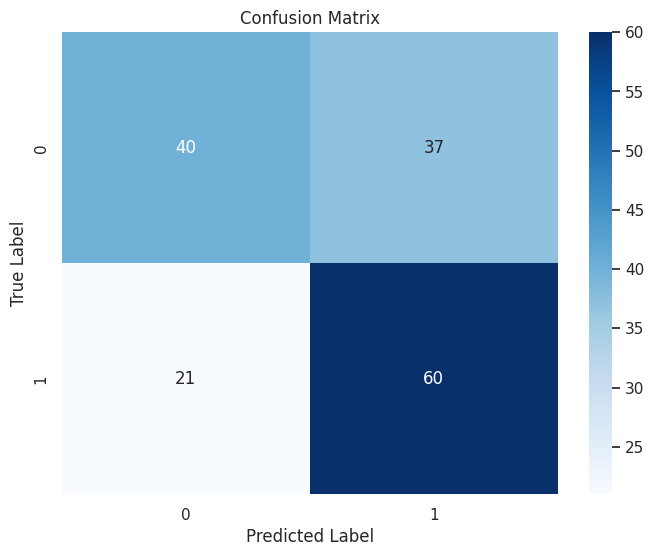

In [ ]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

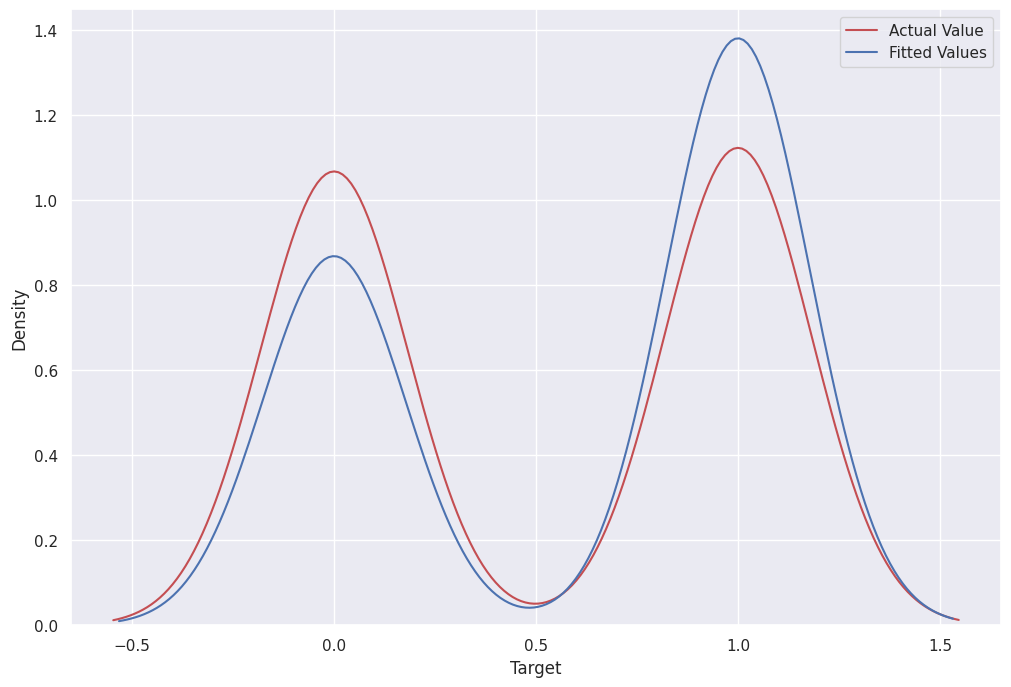

In [ ]:
# distribution plot
ax = sns.distplot(y_test, hist=False, color='r', label='Actual Value')
sns.distplot(y_pred, hist=False, color='b', label='Fitted Values' , ax=ax)
plt.legend()
plt.show()

### Random Forest

In [ ]:
# classification report
print(classification_report(y_test, best_rfc.predict(X_test)))

              precision    recall  f1-score   support

           0       0.80      0.88      0.84        77
           1       0.88      0.79      0.83        81

    accuracy                           0.84       158
   macro avg       0.84      0.84      0.84       158
weighted avg       0.84      0.84      0.84       158



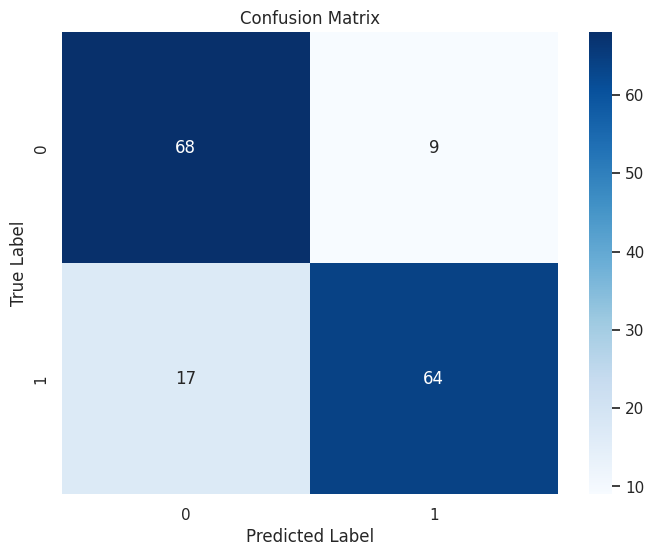

In [ ]:
# confusion matrix
cm = confusion_matrix(y_test, best_rfc.predict(X_test))

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

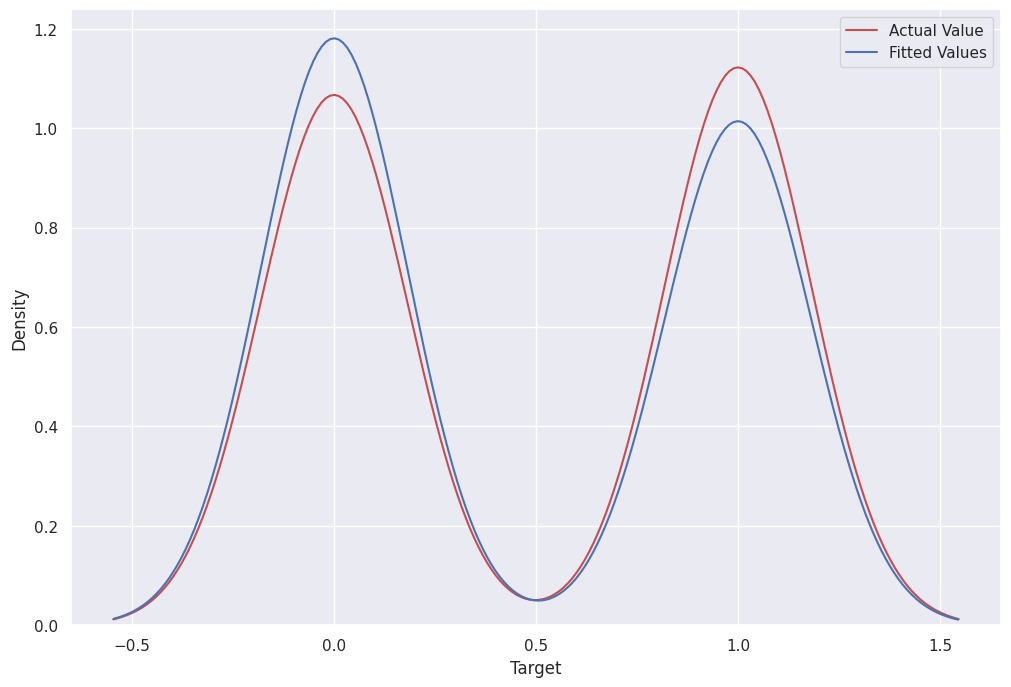

In [ ]:
# distribution plot
ax = sns.distplot(y_test, hist=False, color='r', label='Actual Value')
sns.distplot(best_rfc.predict(X_test), hist=False, color='b', label='Fitted Values' , ax=ax)
plt.legend()
plt.show()

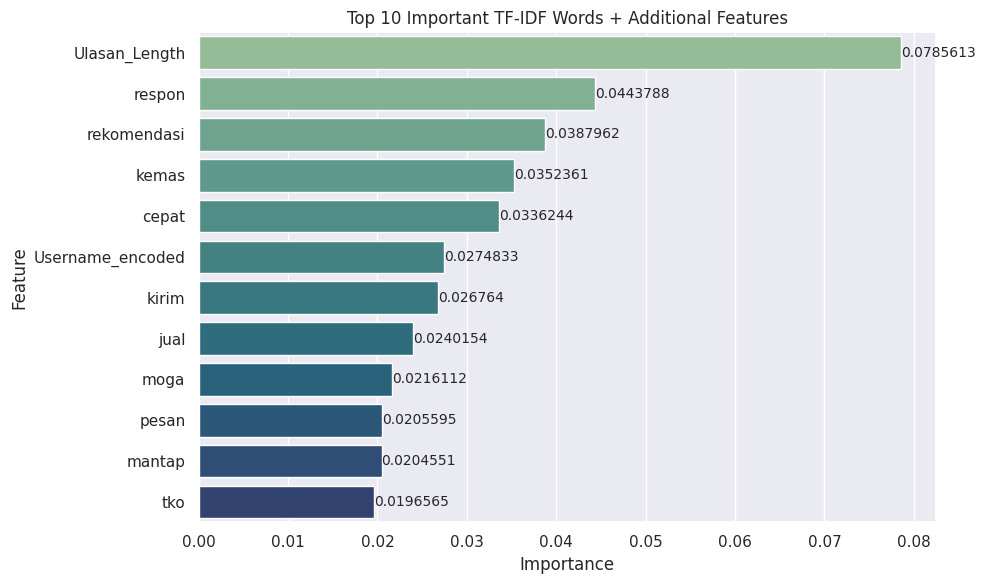

In [ ]:
# feature importance
feature_imp = best_rfc.feature_importances_
feature_names = tfidf.get_feature_names_out()

additional_features = ['Username_encoded', 'Ulasan_Length']

# calculate len tfidf feature
tfidf_len = len(feature_names)

tfidf_feature_imp = feature_imp[:tfidf_len]
tfidf_feature_names = feature_names

# make df and take top 10 TF-IDF words
tfidf_importance_df = pd.DataFrame({
    'Feature': tfidf_feature_names,
    'Importance': tfidf_feature_imp
}).sort_values(by='Importance', ascending=False).head(10)

additional_feature_imp = feature_imp[-2:]
additional_feature_df = pd.DataFrame({
    'Feature': additional_features,
    'Importance': additional_feature_imp
})

# concat
final_df = pd.concat([tfidf_importance_df, additional_feature_df], ignore_index=True)
final_df_sorted = final_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Importance', y='Feature', data=final_df_sorted, palette='crest')
for container in ax.containers:
    ax.bar_label(container, size=10, label_type='edge')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Important TF-IDF Words + Additional Features')
plt.tight_layout()
plt.show()

## Decision Tree

In [ ]:
# classification report
print(classification_report(y_test, best_dtr.predict(X_test)))

              precision    recall  f1-score   support

           0       0.78      0.78      0.78        77
           1       0.79      0.79      0.79        81

    accuracy                           0.78       158
   macro avg       0.78      0.78      0.78       158
weighted avg       0.78      0.78      0.78       158



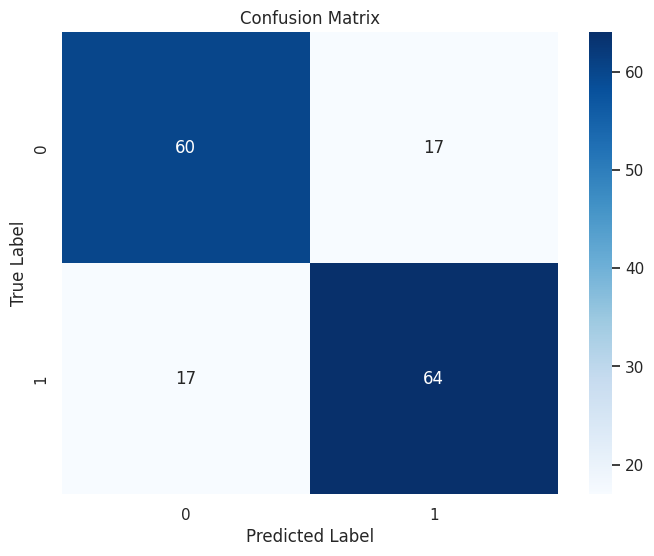

In [ ]:
# confusion matrix
cm = confusion_matrix(y_test, best_dtr.predict(X_test))

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

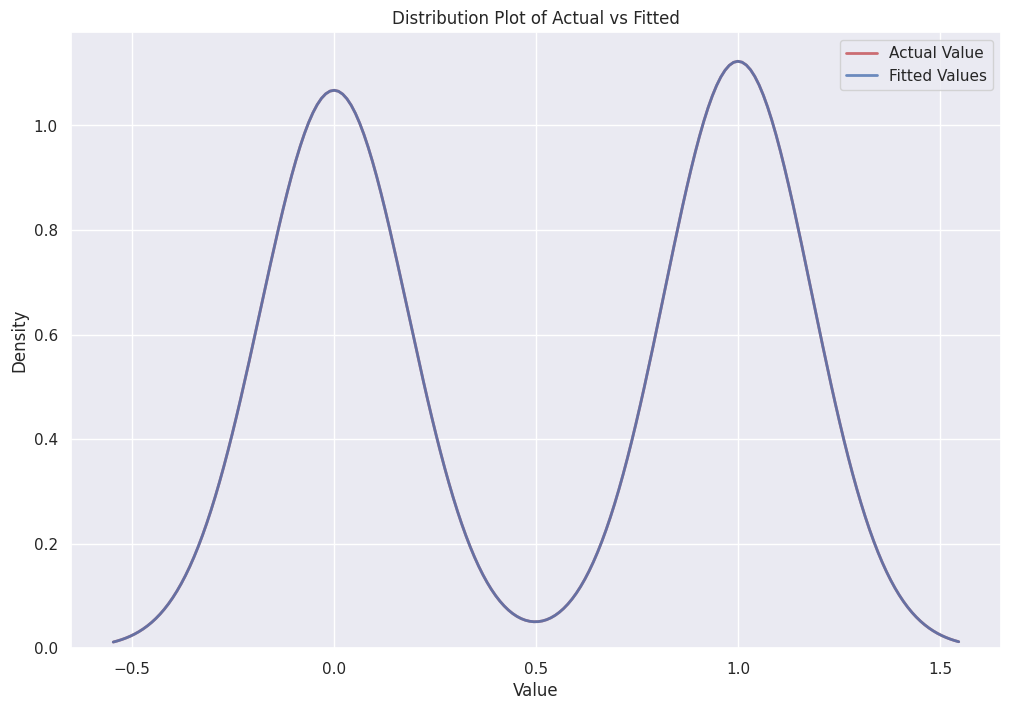

In [ ]:
# distribution plot
ax = sns.kdeplot(y_test, color='r', label='Actual Value', lw=2, alpha=0.8)
sns.kdeplot(best_dtr.predict(X_test), color='b', label='Fitted Values', lw=2, alpha=0.8, ax=ax)

plt.legend()
plt.xlabel("Value")
plt.title("Distribution Plot of Actual vs Fitted")
plt.show()

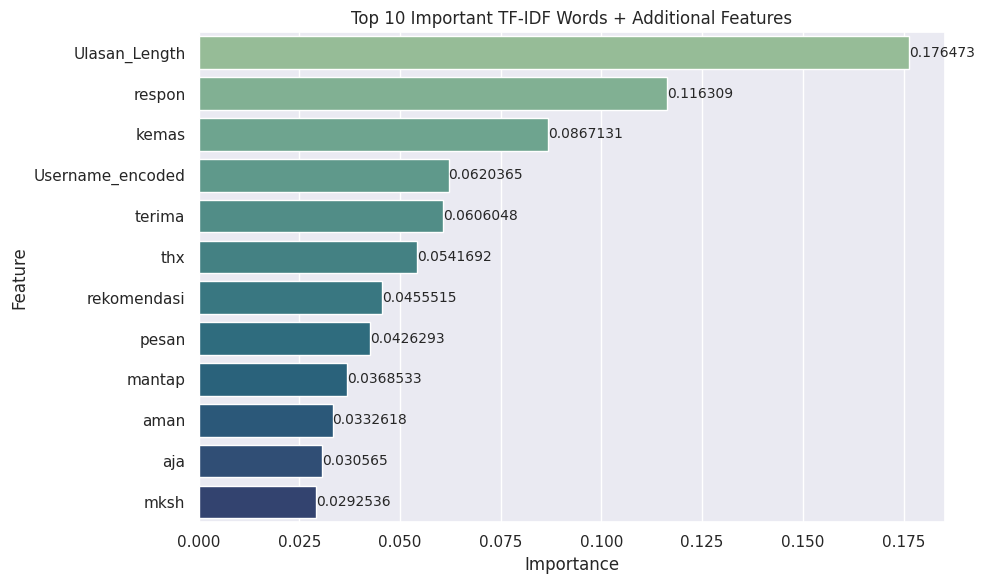

In [ ]:
# feature importance
feature_imp = best_dtr.feature_importances_
feature_names = tfidf.get_feature_names_out()

additional_features = ['Username_encoded', 'Ulasan_Length']

# calculate len tfidf feature
tfidf_len = len(feature_names)

tfidf_feature_imp = feature_imp[:tfidf_len]
tfidf_feature_names = feature_names

# make df and take top 10 TF-IDF words
tfidf_importance_df = pd.DataFrame({
    'Feature': tfidf_feature_names,
    'Importance': tfidf_feature_imp
}).sort_values(by='Importance', ascending=False).head(10)

additional_feature_imp = feature_imp[-2:]
additional_feature_df = pd.DataFrame({
    'Feature': additional_features,
    'Importance': additional_feature_imp
})

# concat
final_df = pd.concat([tfidf_importance_df, additional_feature_df], ignore_index=True)
final_df_sorted = final_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Importance', y='Feature', data=final_df_sorted, palette='crest')
for container in ax.containers:
    ax.bar_label(container, size=10, label_type='edge')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Important TF-IDF Words + Additional Features')
plt.tight_layout()
plt.show()

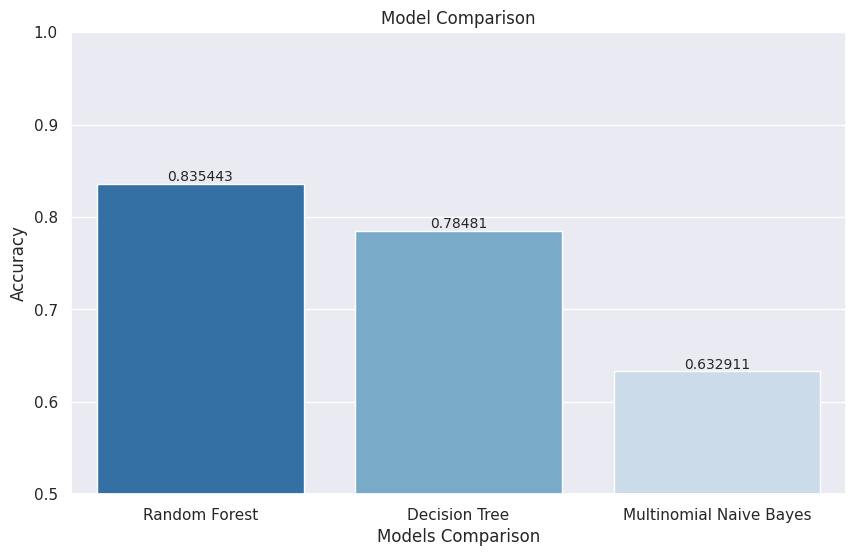

In [ ]:
# model comparison
models = ['Multinomial Naive Bayes', 'Random Forest', 'Decision Tree']
accuracy = [opt.score(X_test, y_test), best_rfc.score(X_test, y_test), best_dtr.score(X_test, y_test)]

# combine models and accuracy
model_comparison = pd.DataFrame({
    'Model': models,
    'Accuracy': accuracy
})

# sort by accuracy in descending order
model_comparison = model_comparison.sort_values(by='Accuracy', ascending=False)

plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Model', y='Accuracy', data=model_comparison, palette='Blues_r')
for container in ax.containers:
    ax.bar_label(container, size=10, label_type='edge')
plt.xlabel('Models Comparison')
plt.ylabel('Accuracy')
plt.title('Model Comparison')
plt.ylim(0.5, 1.0)
plt.show()

## Testing

In [ ]:
# data baru
data_baru = {
    'Username': ['otniel glory'],
    'Ulasan_Clean': ['bagus']
}

df_baru = pd.DataFrame(data_baru)

if df_baru['Username'][0] in username_encoder.classes_:
    df_baru['Username_encoded'] = username_encoder.transform(df_baru['Username'])
else:
    df_baru['Username_encoded'] = -1

df_baru['Ulasan_Length'] = df_baru['Ulasan_Clean'].apply(lambda x: len(x.split()))

X_baru_tfidf = tfidf.transform(df_baru['Ulasan_Clean'])

X_baru_additional = csr_matrix(df_baru[['Username_encoded', 'Ulasan_Length']].values)
X_baru_final = hstack([X_baru_tfidf, X_baru_additional])

# pred
pred_nb = opt.predict(X_baru_final)
pred_rfc = best_rfc.predict(X_baru_final)
pred_dtr = best_dtr.predict(X_baru_final)
print("Hasil Prediksi (Naive Bayes):", pred_nb[0])
print("Hasil Prediksi (Random Forest):", pred_rfc[0])
print("Hasil Prediksi (Decision Tree):", pred_dtr[0])

Hasil Prediksi (Naive Bayes): 1
Hasil Prediksi (Random Forest): 1
Hasil Prediksi (Decision Tree): 0


In [ ]:
# save model nb, rfc and dtr
with open('model_nb.pkl', 'wb') as f:
    pickle.dump(opt.best_estimator_, f)

with open('model_rf.pkl', 'wb') as f:
    pickle.dump(grid_rfc.best_estimator_, f)

with open('model_dt.pkl', 'wb') as f:
    pickle.dump(grid_dtr.best_estimator_, f)

# save tfidf
with open('tfidf.pkl', 'wb') as f:
    pickle.dump(tfidf, f)

# save username_encoder
with open('username_encoder.pkl', 'wb') as f:
    pickle.dump(username_encoder, f)